# CA1 pyramidal cell model specifics
Specifics of the the parameterization for the morphologically detailed CA1 pyramidal cell used in the event-based encodings manuscript. 

This models uses morphology originally from https://doi.org/10.1002/cne.903620103 and hosted on NeuroMorpho.org (https://doi.org/10.1523/jneurosci.2055-07.2007).

Our implementation recieves stimuli independently from 10 excitatory and 5 inhibitory synapses at random locations in the cell's dendrites. 

In [1]:
from neuron import h
from neuron.units import mV, ms
h.load_file("stdrun.hoc")
import matplotlib.pyplot as plt
import plotly
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")
h.load_file("stdrun.hoc")

import sys
import numpy as np
import queue
sys.path.insert(1, "./")
import Stimuli

## set up cell

In [2]:
class Poisson_Times:
    def __init__(self, _id, tau, interval, weight, rev_potential, event_times=None,
                 max_time=1000000, delay=0, start=0, number=99999999):
        self._id = _id
        self.rev_potential = rev_potential
        self.max_time = max_time
        self.interval = interval
        self.weight = weight
        self.delay = delay
        self.tau = tau
        self.start = start
        self.number = number
        self.event_times = []
        
        if event_times:
            # load event times
            self.event_times = event_times
        else:
            # generate event times
            event_time = 0
            for i in range(number):
                event_time += np.random.exponential(self.interval)
                if event_time < max_time:
                    self.event_times.append(event_time)
                else:
                    break
                    
def poisson_times_from_stim_params(stim_params, max_time):
    poisson_times = {}
    for _id in stim_params:
        for seg_ind in stim_params[_id]['seg_inds']:
            poisson_times[seg_ind] = Poisson_Times(
                _id, 
                stim_params[_id]['tau'],
                stim_params[_id]['interval'],
                stim_params[_id]['weight'],
                stim_params[_id]['rev_potential'],
                max_time=max_time
            )
    return poisson_times

In [3]:
class Pyramidal:
    def __init__(self):
        self.load_morphology()
        # do discretization, ion channels, etc
        for sec in self.all:
            sec.nseg = int(1 + 2 * (sec.L // 40))
        h.hh.insert(self.axon)
        h.hh.insert(self.soma)
        h.pas.insert(self.dend)  # passive leak
        h.pas.insert(self.apic)  # passive leak
        self.all_input_segments = []
        for morph in [self.apic, self.dend]:
            for part in morph:
                # self.all_input_segments.append(part)
                self.all_input_segments.extend([seg for seg in part.allseg()])
        # storing input mechanisms
        self.syns = []
        self.net_stims = []
        self.netcons = []
        self.stims = []
        # recording
        self.v_apic = h.Vector().record(self.apic[100](0.5)._ref_v)
        self.v_soma = h.Vector().record(self.soma[0](0.5)._ref_v)
        self.v_axon = h.Vector().record(self.axon[0](0.5)._ref_v)
        self._t = h.Vector().record(h._ref_t)
        self.spike_detector = h.NetCon(self.axon[0](0.5)._ref_v, None, sec=self.axon[0])
        self.spike_times = h.Vector()
        self.spike_detector.record(self.spike_times)

    def __repr__(self):
        return "pyr"

    def load_morphology(self):
        cell = h.Import3d_SWC_read()
        cell.input("./neuron_nmo/amaral/CNG version/c91662.CNG.swc")
        i3d = h.Import3d_GUI(cell, False)
        i3d.instantiate(self)

    def connect_input(self, stimuli, seg):
        '''
        :param stimuli: Poisson_Times class object
        :param seg: NEURON simulation segment
        :return:
        '''
        syn = h.ExpSyn(seg)
        syn.tau = stimuli.tau
        syn.e = stimuli.rev_potential

        vec_stim_times = h.Vector(stimuli.event_times)
        vec_stim = h.VecStim()
        vec_stim.play(vec_stim_times)

        nc = h.NetCon(vec_stim, syn)
        nc.weight[0] = 1  # stimuli.weight
        nc.delay = stimuli.delay

        self.syns.append(syn)
        self.netcons.append(nc)

        netstims = [h.NetStim() for stim_time in stimuli.event_times]
        for netstim, event_time in zip(netstims, stimuli.event_times):
            netstim.number = 1
            netstim.start = event_time
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = stimuli.weight
            netcon.delay = 0 * ms

            self.netcons.append(netcon)
        self.stims.extend(netstims)

    def add_all_inputs(self, stim_sets):
        # stimuli_sets: list of Poisson_Times objects
        seg_inds = np.random.randint(0, len(self.all_input_segments), len(stim_sets))
        for seg_ind, stim_set in zip(seg_inds, stim_sets):
            self.connect_input(stim_set, self.all_input_segments[seg_ind])

In [4]:
pyr = Pyramidal()

stim_params = {
        'e': {
            'n_stim_sets': 10,
            'tau': 2,
            'interval': 25,
            'weight': .25,
            'rev_potential': 0,
            'seg_inds': np.random.randint(0, len(pyr.all_input_segments), 10)
        },
        'i': {
            'n_stim_sets': 5,
            'tau': 6,
            'interval': 25,
            'weight': .25,
            'rev_potential': -80,
            'seg_inds': np.random.randint(0, len(pyr.all_input_segments), 5)
        }
    }

In [5]:
max_time = 1000
stimuli = poisson_times_from_stim_params(stim_params, max_time=max_time)

In [6]:
for seg in stimuli:
    pyr.connect_input(stimuli[seg], pyr.all_input_segments[seg])

In [7]:
h.finitialize(-65)
h.continuerun(max_time)

0.0

In [8]:
def event_type2color(event_type):
    if event_type == 'e':
        return 'red'
    elif event_type == 'i':
        return 'blue'
    elif event_type == 'o':
        return 'green'
    else:
        return 'magenta'

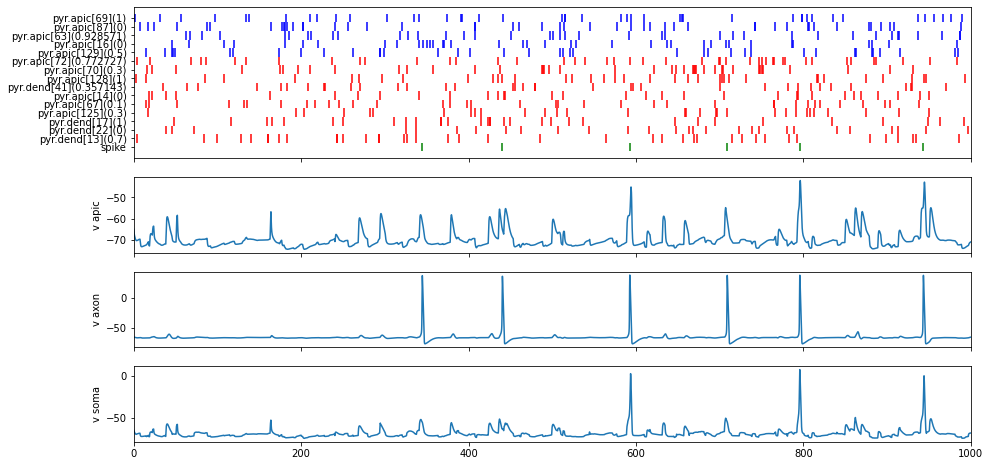

In [9]:
# view stimuli
fig, axes = plt.subplots(4, 1, figsize = (15, 8), sharex=True, gridspec_kw={'height_ratios': [2,1,1,1]})

# inputs
yticks = []
yticklabels = []
for i, seg in enumerate(stimuli):
    axes[0].vlines(stimuli[seg].event_times, i, i+1, color=event_type2color(stimuli[seg]._id))
    yticks.append(i+.5)
    yticklabels.append(str(pyr.all_input_segments[seg]))
    
axes[0].vlines(list(pyr.spike_times), -1, 0, 'green')
yticks.append(-.5)
yticklabels.append('spike')
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(yticklabels)
    
axes[1].plot(pyr._t, pyr.v_apic)
axes[1].set_ylabel('v apic')

axes[2].plot(pyr._t, pyr.v_axon)
axes[2].set_ylabel('v axon')

axes[3].plot(pyr._t, pyr.v_soma)
axes[3].set_ylabel('v soma')

axes[-1].set_xlim(0, max_time)
plt.show()

In [10]:
firing_rate = len(list(pyr.spike_times))
firing_rate

6